# Entorno

In [1]:
import torch
import torchaudio
import numpy as np
import torch.nn as nn
from random import randint
import pytorch_lightning as pl
from pydub import AudioSegment
from scripts.extract import load_heart_noised_paths
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau
from scripts.plot import plot_audio_sample, plot_prediction_from_dataset
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)

# Relación de datos

In [2]:
heart_noised = load_heart_noised_paths(
    clean_dir="data/heart_sound",
    noised_dir="data/heart_noised",
)

heart_noised[:3]

[('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_454noise_-17dB_louder.wav'),
 ('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_550noise_-14dB_louder.wav'),
 ('data/heart_sound/train/healthy/b0123.wav',
  'data/heart_noised/-train-healthy-b0123_seg_106noise_-14dB_louder.wav')]

# Cómo suena?

In [3]:
test = heart_noised[randint(0, len(heart_noised))]

audio_clean = AudioSegment.from_file(test[0])
audio_noisy = AudioSegment.from_file(test[1])

In [4]:
audio_clean

In [5]:
audio_noisy

# Cómo se ve?

In [6]:
clean_array = np.array(audio_clean.get_array_of_samples())
noisy_array = np.array(audio_noisy.get_array_of_samples())
clean_array.shape, noisy_array.shape

((43824,), (43824,))

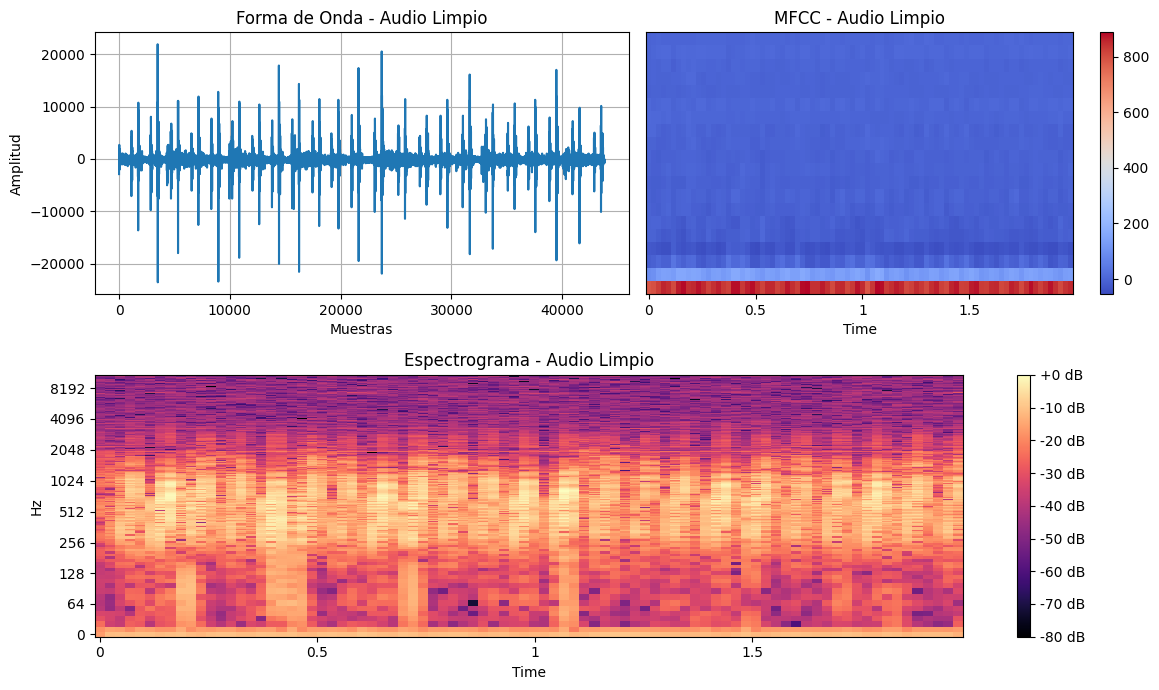

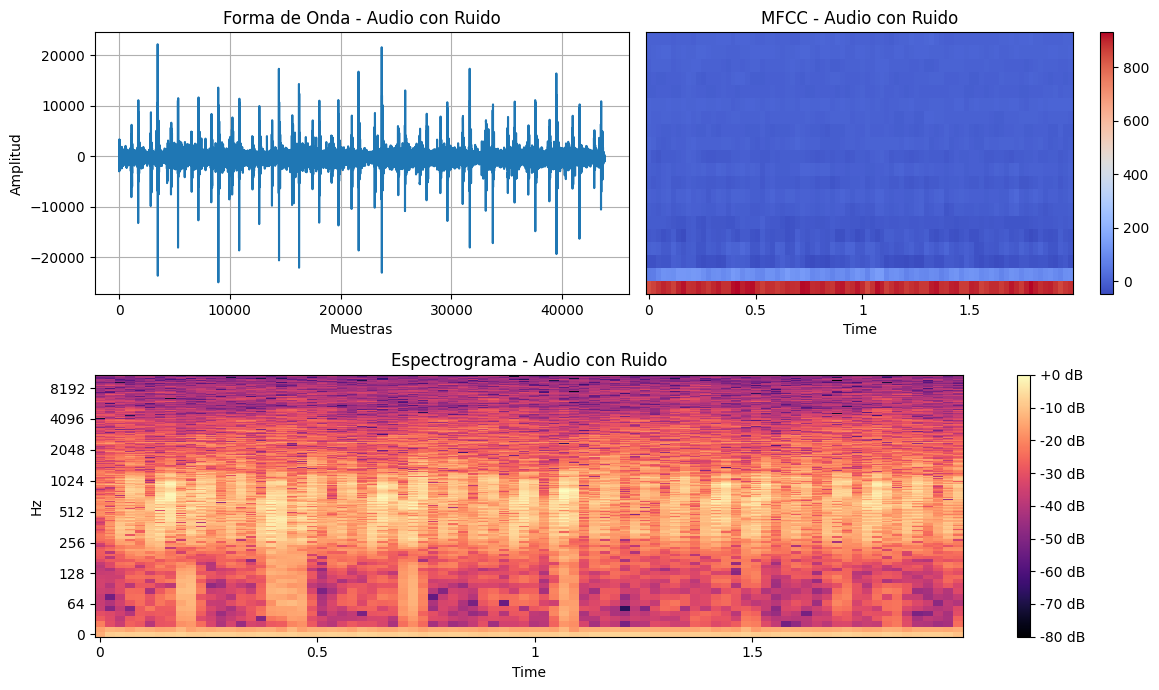

In [7]:
plot_audio_sample(clean_array, "Audio Limpio")
plot_audio_sample(noisy_array, "Audio con Ruido")

# CustomDataset class

In [8]:
class CoraDenoiserDataset(Dataset):
    def __init__(self, data_tuples, transform=None):
        self.data_tuples = data_tuples
        self.transform = transform
        self.min_duration = self.calculate_min_duration(level=10)

    def __len__(self):
        return len(self.data_tuples)

    def calculate_min_duration(self, level: int = 1):
        self.durations = []
        for _, audio_path in self.data_tuples:
            audio, _ = torchaudio.load(audio_path)
            self.durations.append(audio.shape[-1])

        min_dur = min(self.durations) // level
        return min_dur * level

    def adjust_audio_duration(self, audio, duration):
        if audio.shape[-1] > duration:
            audio = audio[..., :duration]
        return audio

    def normalize_audio(self, audio):
        normalized = (audio - audio.mean()) / audio.std()
        return normalized

    def preprocess_audio(self, idx, is_clean):
        subidx = 0 if is_clean else 1
        audio_path = self.data_tuples[idx][subidx]
        audio, sample_rate = torchaudio.load(audio_path)
        audio = self.adjust_audio_duration(audio, self.min_duration)
        audio = self.normalize_audio(audio)
        audio = audio.view(1, 1, -1)
        return audio, sample_rate

    def __getitem__(self, idx):
        clean_audio, sample_rate = self.preprocess_audio(idx, is_clean=True)
        noisy_audio, _ = self.preprocess_audio(idx, is_clean=False)

        if self.transform:
            clean_audio = self.transform(clean_audio, sample_rate)
            noisy_audio = self.transform(noisy_audio, sample_rate)

        return clean_audio, noisy_audio

In [9]:
from scripts.transform import spec_n_mfcc

denoiser_dataset = CoraDenoiserDataset(data_tuples=heart_noised, transform=spec_n_mfcc)

print("Pairs of sounds: ", len(denoiser_dataset))
print("Min audio duration: ", denoiser_dataset.min_duration)
denoiser_dataset[5][0].shape, denoiser_dataset[5][1].shape

Pairs of sounds:  41396
Min audio duration:  10610


(torch.Size([1, 1, 19648]), torch.Size([1, 1, 19648]))

In [10]:
clean = denoiser_dataset[5][0][..., :denoiser_dataset.min_duration]
clean.shape, clean.mean(), clean.std()

(torch.Size([1, 1, 10610]), tensor(-5.4818e-08), tensor(1.))

In [11]:
noisy = denoiser_dataset[5][1][..., :denoiser_dataset.min_duration]
noisy.shape, noisy.mean(), noisy.std()

(torch.Size([1, 1, 10610]), tensor(4.1437e-08), tensor(1.))

# Arquitectura

In [12]:
class DownConvBlock(pl.LightningModule):
    def __init__(
        self,
        input_size,
        output_size,
        kernel_size=3,
        stride=2,
        padding=1,
        norm=True,
        dropout=0.0,
    ):
        super(DownConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size, stride, padding),
            nn.BatchNorm2d(output_size) if norm else nn.Identity(),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(dropout) if dropout else nn.Identity(),
        )

    def forward(self, x):
        output = self.layers(x)
        return output


class UpConvBlock(pl.LightningModule):
    def __init__(
        self, input_size, output_size, kernel_size=4, stride=2, padding=1, dropout=0.0
    ):
        super(UpConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding),
            nn.BatchNorm2d(output_size),
            nn.ReLU(),
            nn.Dropout2d(dropout) if dropout else nn.Identity(),
        )

    def forward(self, x, encod_input):
        x = self.layers(x)
        encod_input = encod_input.repeat((1, 1, x.shape[2], 1))
        output = torch.cat((x, encod_input), dim=1)
        return output

In [17]:
class CoraDenoiser(pl.LightningModule):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_conv1 = DownConvBlock(in_channels, 16, norm=False)
        self.down_conv2 = DownConvBlock(16, 32)
        self.down_conv3 = DownConvBlock(32, 64)

        self.up_conv1 = UpConvBlock(64, 32, dropout=0.2)
        self.up_conv2 = UpConvBlock(64, 16, dropout=0.2)

        self.upsample = nn.Upsample(scale_factor=2)
        self.just_conv = nn.Conv2d(32, out_channels, kernel_size=(8, 1), stride=(8, 1), padding=0)
    
    def forward(self, x):
        # print('\nraw', x.shape)
        enc1 = self.down_conv1(x)
        # print('\nenc1', enc1.shape)
        enc2 = self.down_conv2(enc1)
        # print('\nenc2', enc2.shape)
        enc3 = self.down_conv3(enc2)
        # print('\nenc3', enc3.shape)

        dec1 = self.up_conv1(enc3, enc2)
        # print('\ndec1', dec1.shape)
        dec2 = self.up_conv2(dec1, enc1)
        # print('\ndec2', dec2.shape)

        upsample = self.upsample(dec2)
        # print("\nupsample", upsample.shape)
        final = self.just_conv(upsample)
        # print('\nfinal', final.shape)
        
        return final

    def training_step(self, batch, batch_idx):
        clean, noisy = batch
        # Forward pass
        decoded = self(noisy)
        # Calculamos la pérdida (error de reconstrucción)
        train_loss = nn.MSELoss()(decoded, clean)
        # Registramos la pérdida para su monitoreo
        self.log("train_loss", train_loss, on_epoch=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        clean, noisy = batch
        decoded = self(noisy)
        val_loss = nn.MSELoss()(decoded, clean)
        self.log("val_loss", val_loss, on_epoch=True)

        return val_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = {
            "scheduler": CyclicLR(
                optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=False
            ),
            "interval": "step",  # Frecuencia de ajuste del LR scheduler (en cada paso)
        }

        # # Otra opción
        # optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        # scheduler = {
        #     'scheduler': ReduceLROnPlateau(optimizer, patience=3),
        #     'monitor': 'val_loss',  # Métrica para monitorear
        #     'interval': 'epoch',    # Frecuencia de ajuste del LR scheduler
        #     'frequency': 1          # Igual a interval, ya que estamos usando 'epoch'
        # }

        return [optimizer], [scheduler]

# Entrenamiento, validación y prueba

In [18]:
batch_size = 56
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(denoiser_dataset))
val_size = int(val_ratio * len(denoiser_dataset))
test_size = len(denoiser_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    denoiser_dataset, [train_size, val_size, test_size]
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

# Callbacks

In [19]:
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="autoencoder-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

lr_monitor = LearningRateMonitor(logging_interval="epoch")

# callbacks = [checkpoint, early_stopping, lr_monitor]
callbacks = [checkpoint, lr_monitor]

# Entrenamiento

In [20]:
model = CoraDenoiser()

logger = TensorBoardLogger("logs/", name="cora_cleaner")

trainer = pl.Trainer(max_epochs=1, callbacks=callbacks, logger=logger)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type          | Params
---------------------------------------------
0 | down_conv1 | DownConvBlock | 160   
1 | down_conv2 | DownConvBlock | 4.7 K 
2 | down_conv3 | DownConvBlock | 18.6 K
3 | up_conv1   | UpConvBlock   | 32.9 K
4 | up_conv2   | UpConvBlock   | 16.4 K
5 | upsample   | Upsample      | 0     
6 | just_conv  | Conv2d        | 257   
---------------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 518/518 [11:15<00:00,  1.30s/it, v_num=2]        

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 518/518 [11:15<00:00,  1.30s/it, v_num=2]


# Predicción

In [23]:
from torch import Tensor, no_grad
def plot_prediction_from_dataset(model, dataset, duration, idx):
    with no_grad():
        model.eval()
        reshaped = dataset[idx][1].unsqueeze(0)
        pred = model(reshaped)

    noisy = dataset[idx][1][..., :duration]
    print(noisy.shape, noisy.mean(), noisy.std())
    plot_audio_sample(noisy.squeeze(), "Audio sucio")

    decoded = pred[..., :duration]
    print(decoded.shape, decoded.mean(), decoded.std())
    plot_audio_sample(decoded.squeeze(), "Audio reconstruido")

    clean = dataset[idx][0][..., :duration]
    print(clean.shape, clean.mean(), clean.std())
    plot_audio_sample(clean.squeeze(), "Audio limpio")

In [ ]:
# Descomentar para revisar el Tensorboard en web
# !tensorboard --logdir=path_to_logs_directory

# Otra opción es VisualStudioCode: Ctrl+Shift+P -> Launch Tensorboard